In [561]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import json
import os 
from sklearn.preprocessing import StandardScaler

In [562]:
selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi',
                    'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)'] 

#  'AP1_StdDev (mm)','AP2_StdDev (mm)','AP3_StdDev (mm)','AP4_StdDev (mm)',

In [563]:
# 1. 讀取資料
file_path = "timestamp_allignment_2024_12_14_rtt_logs.csv"

date = "2024_12_14"

data = pd.read_csv(file_path, usecols=selected_columns)

print(data.head())

   Label  AP1_Distance (mm)  AP2_Distance (mm)  AP3_Distance (mm)  \
0     10             3849.0             8159.0            10361.0   
1     10             4380.0             7046.0            10361.0   
2     10             4467.0             7456.0            10257.0   
3     10             4819.0             7163.0            10439.0   
4     10             4409.0             6518.0            10088.0   

   AP4_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi  
0             -967.0     -58.0     -75.0     -70.0     -56.0  
1              -69.0     -58.0     -75.0     -69.0     -57.0  
2             1072.0     -59.0     -75.0     -69.0     -58.0  
3              985.0     -60.0     -74.0     -69.0     -51.0  
4             -108.0     -58.0     -69.0     -66.0     -56.0  


In [564]:
label_to_coordinates = {
    "1-1": (0, 0), "1-2": (0.6, 0), "1-3": (1.2, 0), "1-4": (1.8, 0), "1-5": (2.4, 0), "1-6": (3.0, 0),"1-7": (3.6, 0), "1-8": (4.2, 0), "1-9": (4.8, 0), "1-10": (5.4, 0), "1-11": (6.0, 0),
    "2-1": (0, 0.6), "2-11": (6.0, 0.6),
    "3-1": (0, 1.2), "3-11": (6.0, 1.2),
    "4-1": (0, 1.8), "4-11": (6.0, 1.8),
    "5-1": (0, 2.4), "5-11": (6.0, 2.4),
    "6-1": (0, 3.0), "6-2": (0.6, 3.0), "6-3": (1.2, 3.0), "6-4": (1.8, 3.0), "6-5": (2.4, 3.0),"6-6": (3.0, 3.0), "6-7": (3.6, 3.0), "6-8": (4.2, 3.0), "6-9": (4.8, 3.0), "6-10": (5.4, 3.0), "6-11": (6.0, 3.0),
    "7-1": (0, 3.6), "7-11": (6.0, 3.6),
    "8-1": (0, 4.2), "8-11": (6.0, 4.2),
    "9-1": (0, 4.8), "9-11": (6.0, 4.8),
    "10-1": (0, 5.4), "10-11": (6.0, 5.4),
    "11-1": (0, 6.0), "11-2": (0.6, 6.0), "11-3": (1.2, 6.0), "11-4": (1.8, 6.0), "11-5": (2.4, 6.0),"11-6": (3.0, 6.0), "11-7": (3.6, 6.0), "11-8": (4.2, 6.0), "11-9": (4.8, 6.0), "11-10": (5.4, 6.0), "11-11": (6.0, 6.0)
}

In [565]:
label_mapping = {
    '11': '1-1','10': '1-2','9': '1-3','8': '1-4','7': '1-5','6': '1-6','5': '1-7','4': '1-8','3': '1-9','2': '1-10','1': '1-11',
    '12': '2-1','30': '2-11',
    '13': '3-1','29': '3-11',
    '14': '4-1','28': '4-11',
    '15': '5-1','27': '5-11',
    '16': '6-1','17': '6-2','18': '6-3','19': '6-4','20': '6-5','21': '6-6','22': '6-7','23': '6-8','24': '6-9','25': '6-10','26': '6-11',
    '49': '7-1','31': '7-11',
    '48': '8-1','32': '8-11',
    '47': '9-1','33': '9-11',
    '46': '10-1','34': '10-11',
    '45': '11-1','44': '11-2','43': '11-3','42': '11-4','41': '11-5','40': '11-6','39': '11-7','38': '11-8','37': '11-9','36': '11-10','35': '11-11'
}

In [566]:
target_column = 'Label'  # 替換成目標欄位名稱
# 替換目標欄位的 label
data[target_column] = data[target_column].astype(str).map(label_mapping)
# 確認是否有未映射的值
unmapped_values = data[target_column][data[target_column].isna()].unique()
if len(unmapped_values) > 0:
    print("以下值未找到對應的映射：", unmapped_values)

In [567]:
test_size=0.2
val_size=0.1

target_column = 'Label'  # 替換成目標欄位名稱

In [568]:
label_column = 'Label'

In [569]:
# 資料前處理 (一): 刪除前後n筆資料
n = 20
# 確保依據Label排序
data = data.sort_values(by=label_column).reset_index(drop=True)

# 建立一個空的 DataFrame 用於存放處理後的資料
processed_data = pd.DataFrame(columns=data.columns)

# 針對每個Label群組進行處理
for label, group in data.groupby(label_column):
    # 刪除前n筆和後n筆資料
    if len(group) > 2 * n:  # 確保群組資料足夠
        group = group.iloc[n:-n]
    else:
        group = pd.DataFrame()  # 若資料不足，刪除整個群組
    # 將處理後的群組資料加入
    processed_data = pd.concat([processed_data, group], ignore_index=True)

processed_data


/tmp/ipykernel_2957851/3563538803.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)


,Label,AP1_Distance (mm),AP2_Distance (mm),AP3_Distance (mm),AP4_Distance (mm),AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
0,1-1,4272.0,6489.0,11846.0,-577.0,-63.0,-73.0,-65.0,-55.0
1,1-1,4311.0,6665.0,11924.0,-772.0,-63.0,-73.0,-65.0,-54.0
2,1-1,3799.0,6577.0,12002.0,-811.0,-57.0,-72.0,-66.0,-55.0
3,1-1,4155.0,6577.0,11924.0,-772.0,-63.0,-73.0,-66.0,-55.0
4,1-1,4038.0,6518.0,11846.0,-889.0,-63.0,-72.0,-65.0,-55.0
...,...,...,...,...,...,...,...,...,...
20307,9-11,1577.0,5718.0,3018.0,4852.0,-52.0,-69.0,-52.0,-66.0
20308,9-11,1538.0,5796.0,2822.0,4813.0,-58.0,-69.0,-52.0,-66.0
20309,9-11,1538.0,5835.0,2822.0,4676.0,-58.0,-69.0,-52.0,-61.0
20310,9-11,1538.0,6147.0,2783.0,4881.0,-58.0,-69.0,-52.0,-66.0


In [570]:
# Calculate the number of rows with NaN values
nan_rows = processed_data.isnull().any(axis=1).sum()

# Print the result
print(f"Number of rows with NaN values: {nan_rows}")

# 找出包含 NaN 的列
rows_with_nan = processed_data[processed_data.isnull().any(axis=1)]

# 印出這些列
print("Rows with NaN values:")
print(rows_with_nan)

Number of rows with NaN values: 1056
Rows with NaN values:
      Label  AP1_Distance (mm)  AP2_Distance (mm)  AP3_Distance (mm)  \
32      1-1                NaN                NaN                NaN   
33      1-1             4116.0             6665.0            11963.0   
35      1-1             4077.0                NaN            11768.0   
36      1-1                NaN             6811.0                NaN   
66      1-1             4038.0                NaN            11689.0   
...     ...                ...                ...                ...   
20279  9-11             1655.0             5913.0             2822.0   
20284  9-11                NaN             5639.0                NaN   
20285  9-11             1616.0                NaN             2666.0   
20292  9-11             1538.0             5639.0                NaN   
20293  9-11                NaN                NaN             2822.0   

       AP4_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi  
32       

In [571]:
data_imputed = processed_data.groupby(label_column).apply(
    lambda group: group.fillna(group.mean())
).reset_index()
data_imputed

,Label,level_1,AP1_Distance (mm),AP2_Distance (mm),AP3_Distance (mm),AP4_Distance (mm),AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
0,1-1,0,4272.0,6489.0,11846.0,-577.0,-63.0,-73.0,-65.0,-55.0
1,1-1,1,4311.0,6665.0,11924.0,-772.0,-63.0,-73.0,-65.0,-54.0
2,1-1,2,3799.0,6577.0,12002.0,-811.0,-57.0,-72.0,-66.0,-55.0
3,1-1,3,4155.0,6577.0,11924.0,-772.0,-63.0,-73.0,-66.0,-55.0
4,1-1,4,4038.0,6518.0,11846.0,-889.0,-63.0,-72.0,-65.0,-55.0
...,...,...,...,...,...,...,...,...,...,...
20307,9-11,20307,1577.0,5718.0,3018.0,4852.0,-52.0,-69.0,-52.0,-66.0
20308,9-11,20308,1538.0,5796.0,2822.0,4813.0,-58.0,-69.0,-52.0,-66.0
20309,9-11,20309,1538.0,5835.0,2822.0,4676.0,-58.0,-69.0,-52.0,-61.0
20310,9-11,20310,1538.0,6147.0,2783.0,4881.0,-58.0,-69.0,-52.0,-66.0


In [572]:
k = 5
n_neighbors = 5



In [573]:
# Step 3: 修改為支持 K-fold 的 KNN 評估並計算平均混淆矩陣
kf = KFold(n_splits=k, shuffle=True, random_state=42)
overall_accuracy = []
fold_reports = []

overall_mde = []  # 用於儲存每個 fold 的平均 MDE
mde_report = {}


# 初始化儲存所有 folds 的真實值和預測值
all_y_test = []
all_y_test_pred = []

In [574]:
# 建立 Label 映射
y = data_imputed[target_column]
# label_mapping = {str(i): label for i, label in enumerate(y.unique())}
reverse_label_mapping = {v: int(k) - 1 for k, v in label_mapping.items()}  # 讓數字標籤 -1
y_numeric = y.map(reverse_label_mapping)

print("Final reverse_label_mapping in DNN:", reverse_label_mapping)
print("y_numeric unique values in DNN:", y_numeric.unique())

Final reverse_label_mapping in DNN: {'1-1': 10, '1-2': 9, '1-3': 8, '1-4': 7, '1-5': 6, '1-6': 5, '1-7': 4, '1-8': 3, '1-9': 2, '1-10': 1, '1-11': 0, '2-1': 11, '2-11': 29, '3-1': 12, '3-11': 28, '4-1': 13, '4-11': 27, '5-1': 14, '5-11': 26, '6-1': 15, '6-2': 16, '6-3': 17, '6-4': 18, '6-5': 19, '6-6': 20, '6-7': 21, '6-8': 22, '6-9': 23, '6-10': 24, '6-11': 25, '7-1': 48, '7-11': 30, '8-1': 47, '8-11': 31, '9-1': 46, '9-11': 32, '10-1': 45, '10-11': 33, '11-1': 44, '11-2': 43, '11-3': 42, '11-4': 41, '11-5': 40, '11-6': 39, '11-7': 38, '11-8': 37, '11-9': 36, '11-10': 35, '11-11': 34}
y_numeric unique values in DNN: [10  1  0  9  8  7  6  5  4  3  2 45 33 44 35 34 43 42 41 40 39 38 37 36
 11 29 12 28 13 27 14 26 15 24 25 16 17 18 19 20 21 22 23 48 30 47 31 46
 32]


In [575]:
# 把label部分拿掉
X = data_imputed.drop(columns=['level_1','Label'])

scaler = StandardScaler()
columns_to_scale = selected_columns.copy()  # 建立副本，避免影響原始變數
columns_to_scale.remove('Label')  # 在副本上移除 'Label'
X_scaled = scaler.fit_transform(X[columns_to_scale])

print(X_scaled[0])

X

[-0.54669493 -1.06140445 -1.29307497  0.41467352  0.62961422  0.43750829
  1.89336121 -1.33898772]


,AP1_Distance (mm),AP2_Distance (mm),AP3_Distance (mm),AP4_Distance (mm),AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
0,4272.0,6489.0,11846.0,-577.0,-63.0,-73.0,-65.0,-55.0
1,4311.0,6665.0,11924.0,-772.0,-63.0,-73.0,-65.0,-54.0
2,3799.0,6577.0,12002.0,-811.0,-57.0,-72.0,-66.0,-55.0
3,4155.0,6577.0,11924.0,-772.0,-63.0,-73.0,-66.0,-55.0
4,4038.0,6518.0,11846.0,-889.0,-63.0,-72.0,-65.0,-55.0
...,...,...,...,...,...,...,...,...
20307,1577.0,5718.0,3018.0,4852.0,-52.0,-69.0,-52.0,-66.0
20308,1538.0,5796.0,2822.0,4813.0,-58.0,-69.0,-52.0,-66.0
20309,1538.0,5835.0,2822.0,4676.0,-58.0,-69.0,-52.0,-61.0
20310,1538.0,6147.0,2783.0,4881.0,-58.0,-69.0,-52.0,-66.0


In [576]:
# 設定 KFold 交叉驗證
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_y_test, all_y_test_pred = [], []
overall_accuracy, overall_mde = [], []
mde_report, fold_reports = {}, []
fold_index = 1

mde_report_per_fold = {}

In [577]:
print("X type")
print(X.dtypes)
print("y type")
print(y.dtypes)

X type
AP1_Distance (mm)    float64
AP2_Distance (mm)    float64
AP3_Distance (mm)    float64
AP4_Distance (mm)    float64
AP1_Rssi             float64
AP2_Rssi             float64
AP3_Rssi             float64
AP4_Rssi             float64
dtype: object
y type
object


In [578]:
# 進行 5-Fold 交叉驗證
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_numeric.iloc[train_index], y_numeric.iloc[test_index]

    # 建立 DNN 模型
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(len(label_mapping), activation='softmax')
    ])

    # 編譯模型
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 訓練模型
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # 進行預測
    y_test_pred_numeric = model.predict(X_test)
    y_pred_classes = np.argmax(y_test_pred_numeric, axis=1)
    # y_test_pred_labels = [label_mapping[str(num)] for num in y_pred_classes]
    y_test_pred_labels = [label_mapping[str(num + 1)] for num in y_pred_classes]  # 補回 +1


    # 計算 MDE
    y_test_pred_coordinates = np.array([label_to_coordinates[label] for label in y_test_pred_labels])
    # y_test_coordinates = np.array([label_to_coordinates[label_mapping[str(label)]] for label in y_test])
    y_test_coordinates = np.array([label_to_coordinates[label_mapping[str(label + 1)]] for label in y_test])


    distances = np.linalg.norm(y_test_pred_coordinates - y_test_coordinates, axis=1)
    fold_mde = np.mean(distances)
    overall_mde.append(fold_mde)

    # 記錄每個 RP 在當前 fold 的 MDE
    for true_label, distance in zip(y_test, distances):
        if true_label not in mde_report_per_fold:
            mde_report_per_fold[true_label] = []
        mde_report_per_fold[true_label].append(distance)  # 存所有 fold 的 MDE


    print(f"Fold {fold_index} - MDE: {fold_mde:.4f}")
    

    fold_index += 1
    

# 計算 5-Fold 平均 MDE
mde_report_avg = {label: {"mde": np.mean(distances), "count": len(distances)} for label, distances in mde_report_per_fold.items()}

# 儲存到 JSON 檔案
file_path = f"mde_report_avg_{date}.json"
with open(file_path, "w") as f:
    json.dump(mde_report_avg, f, indent=4)

print(f"5-Fold Average MDE report saved to: {file_path}")

# 儲存 DNN 模型
model.save("DNN_model_savednn_indoor_positioning_model.h5")

/home/mcslab/anaconda3/envs/TingYang_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
Fold 1 - MDE: 0.0081
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 - MDE: 0.0081
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
Fold 3 - MDE: 0.0029
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 4 - MDE: 0.0058
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


Fold 5 - MDE: 0.0170
5-Fold Average MDE report saved to: mde_report_avg_2024_12_14.json


In [579]:
# 計算 5-Fold 平均 MDE
mean_mde = np.mean(overall_mde)
print(f"\n5-Fold Mean MDE: {mean_mde:.4f} meters")


5-Fold Mean MDE: 0.0084 meters


In [580]:
input_file_path = f'mde_report_avg_{date}.json'

In [581]:
import json

with open(input_file_path, "r") as file:
    mde_data = json.load(file)

label_mapping = {
    '11': '1-1','10': '1-2','9': '1-3','8': '1-4','7': '1-5','6': '1-6','5': '1-7','4': '1-8','3': '1-9','2': '1-10','1': '1-11',
    '12': '2-1','30': '2-11',
    '13': '3-1','29': '3-11',
    '14': '4-1','28': '4-11',
    '15': '5-1','27': '5-11',
    '16': '6-1','17': '6-2','18': '6-3','19': '6-4','20': '6-5','21': '6-6','22': '6-7','23': '6-8','24': '6-9','25': '6-10','26': '6-11',
    '49': '7-1','31': '7-11',
    '48': '8-1','32': '8-11',
    '47': '9-1','33': '9-11',
    '46': '10-1','34': '10-11',
    '45': '11-1','44': '11-2','43': '11-3','42': '11-4','41': '11-5','40': '11-6','39': '11-7','38': '11-8','37': '11-9','36': '11-10','35': '11-11'
}

# 轉換數字索引為對應的 label
# converted_mde_data = {label_mapping[key]: value for key, value in mde_data.items() if key in label_mapping}
converted_mde_data = {label_mapping[str(int(key) + 1)]: value for key, value in mde_data.items() if str(int(key) + 1) in label_mapping}


# 儲存轉換後的 JSON 檔案
output_file_path = f"DNN_mde_report_{date}.json"  # 你可以自訂輸出的檔名

with open(output_file_path, "w") as f:
    json.dump(converted_mde_data, f, indent=4)

print(f"MDE report has been saved to: {output_file_path}")


MDE report has been saved to: DNN_mde_report_2024_12_14.json


In [582]:
ti = "DNN rssi rtt"

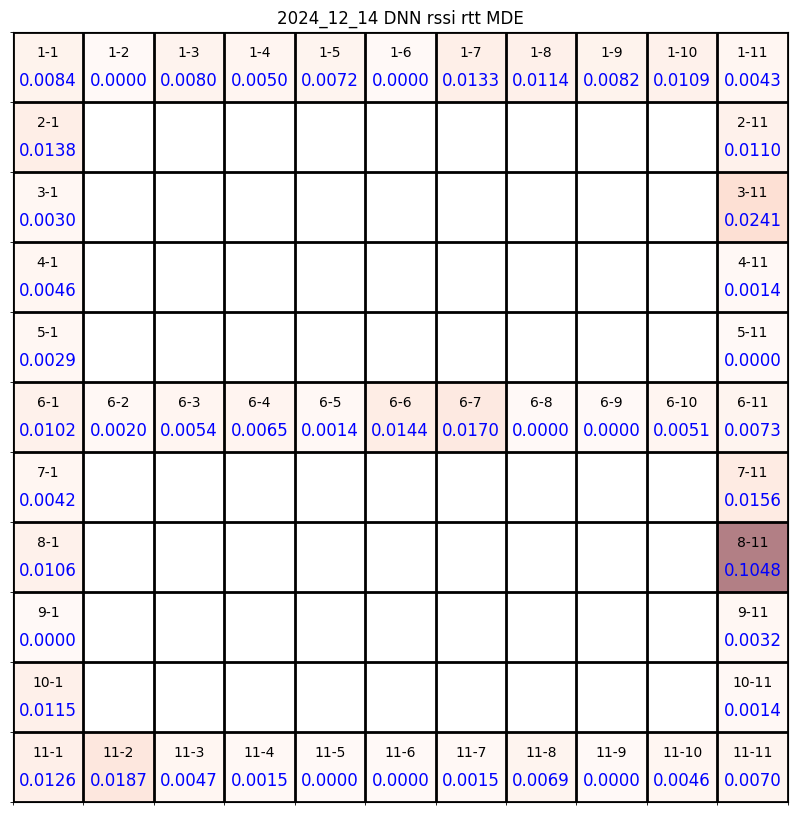

In [583]:
Title = f"{date} {ti} MDE"
file_path = f"DNN_mde_report_{date}.json"

# 載入 JSON 報告
with open(file_path) as file:
    mde_data = json.load(file)

# 將 MDE 填入網格
rows, cols = 11, 11
grid = np.full((rows, cols), np.nan)  # 初始化網格
labels = np.empty((rows, cols), dtype=object)  # 初始化標籤

# 填充網格數據
for key, value in mde_data.items():
    if '-' in key:
        r, c = map(int, key.split('-'))
        grid[rows - r, c - 1] = value["mde"]  # 反轉行索引以正確對應圖表
        labels[rows - r, c - 1] = key

# 繪製圖表
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Reds  # 顏色映射

# 畫出每個網格
for i in range(rows):
    for j in range(cols):
        value = grid[i, j]
        label = labels[i, j]
        if not np.isnan(value):
            ax.text(j, i + 0.2, f'{label}', ha='center', va='center', color='black', fontsize=10)
            ax.text(j, i - 0.2, f'{value:.4f}', ha='center', va='center', color='blue', fontsize=12)
        rect_color = cmap(value / np.nanmax(grid)) if not np.isnan(value) else 'white'
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color, alpha=0.5))

# 格式化圖表
ax.set_xlim(-0.5, cols - 0.5)
ax.set_ylim(-0.5, rows - 0.5)
ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.title(Title)
plt.show()


In [584]:
# # 進行 5-Fold 交叉驗證
# for train_index, test_index in kf.split(X_scaled):
#     X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#     y_train, y_test = y_numeric.iloc[train_index], y_numeric.iloc[test_index]

#     # 建立 DNN 模型
#     model = keras.Sequential([
#         keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#         keras.layers.Dense(128, activation='relu'),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dense(len(label_mapping), activation='softmax')
#     ])

#     # 編譯模型
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     # 訓練模型
#     model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

#     # 進行預測
#     y_test_pred_numeric = model.predict(X_test)
#     y_pred_classes = np.argmax(y_test_pred_numeric, axis=1)
#     y_test_pred_labels = [label_mapping[str(num)] for num in y_pred_classes]

#     # 計算準確率與 MDE
#     all_y_test.extend(y_test)
#     all_y_test_pred.extend(y_test_pred_labels)
#     accuracy = accuracy_score(y_test, y_test_pred_labels)
#     overall_accuracy.append(accuracy)
    
#     # MDE 計算
#     y_test_pred_coordinates = np.array([label_to_coordinates[label] for label in y_test_pred_labels])
#     y_test_coordinates = np.array([label_to_coordinates[label_mapping[str(label)]] for label in y_test])
#     distances = np.linalg.norm(y_test_pred_coordinates - y_test_coordinates, axis=1)
#     fold_mde = np.mean(distances)
#     overall_mde.append(fold_mde)
    
#     for true_label, distance in zip(y_test, distances):
#         if true_label not in mde_report:
#             mde_report[true_label] = []
#         mde_report[true_label].append(distance)
    

#     y_test_pred_numeric = np.array([reverse_label_mapping[label] for label in y_test_pred_labels])
#     report = classification_report(y_test, y_test_pred_numeric, target_names=[str(label) for label in np.unique(y)], zero_division=0, output_dict=True)
#     fold_reports.append(report)
    
#     print(f"Fold {fold_index} - Accuracy: {accuracy:.4f}")
#     print(f"Fold {fold_index} - MDE: {fold_mde:.4f}")
#     fold_index += 1

# # 計算 5-Fold 平均 MDE
# mean_mde = np.mean(overall_mde)
# print(f"\n5-Fold Mean MDE: {mean_mde:.4f} meters")

# # 儲存 DNN 模型
# model.save("DNN_model_save\\dnn_indoor_positioning_model.h5")


# # 計算 5-Fold 平均 MDE
# mde_report_avg = {label: {"mde": np.mean(distances), "count": len(distances)} for label, distances in mde_report_per_fold.items()}

# # 儲存到 JSON 檔案
# file_path = f"mde_report_avg_{date}.json"
# with open(file_path, "w") as f:
#     json.dump(mde_report_avg, f, indent=4)

# print(f"5-Fold Average MDE report saved to: {file_path}")